# BEE 4750 Homework 5: Mixed Integer and Stochastic Programming

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 12/05/24, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will use mixed integer programming to solve a
    waste load allocation problem.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `/home2/ajv85/hw5-joever`
Precompiling project...
  ✓ Graphite2_jll
  ✓ StableRNGs
  ✓ GeoFormatTypes
  ✓ OpenSSL_jll
  ✓ CommonSubexpressions
  ✓ HiGHS_jll
  ✓ LaTeXStrings
  ✓ Adapt
  ✓ TranscodingStreams
  ✓ LoggingExtras
  ✓ ConstructionBase
  ✓ LLVMOpenMP_jll
  ✓ SentinelArrays
  ✓ Libmount_jll
  ✓ EpollShim_jll
  ✓ ChainRulesCore
  ✓ StringManipulation
  ✓ Bzip2_jll
  ✓ Xorg_libICE_jll
  ✓ Xorg_libXau_jll
  ✓ JpegTurbo_jll
  ✓ gperf_jll
  ✓ libpng_jll
  ✓ libfdk_aac_jll
  ✓ fzf_jll
  ✓ EarCut_jll
  ✓ LAME_jll
  ✓ LERC_jll
  ✓ XZ_jll
  ✓ Ogg_jll
  ✓ mtdev_jll
  ✓ x265_jll
  ✓ Xorg_libXdmcp_jll
  ✓ MutableArithmetics
  ✓ Zstd_jll
  ✓ Expat_jll
  ✓ LZO_jll
  ✓ Opus_jll
  ✓ x264_jll
  ✓ libaom_jll
  ✓ Xorg_xtrans_jll
  ✓ libevdev_jll
  ✓ Libiconv_jll
  ✓ Libffi_jll
  ✓ Libgpg_error_jll
  ✓ Wayland_protocols_jll
  ✓ OpenSpecFun_jll
  ✓ Xorg_libpthread_stubs_jll
  ✓ Libuuid_jll
  ✓ FriBidi_jll
  ✓ StaticArrays
  ✓ ConstructionBase → ConstructionBaseLinearAlgebra

In [2]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


## Problems (Total: 30 Points)

### Problem 1 (30 points)

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided below.

-   **LF**: Capacity 200 Mg, fixed cost \$2000/day, tipping cost
    \$50/Mg;
-   **MRF**: Capacity 350 Mg, fixed cost \$1500/day, tipping cost
    \$7/Mg, recycling cost \$40/Mg recycled;
-   **WTE**: Capacity 210 Mg, fixed cost \$2500/day, tipping cost
    \$60/Mg;

The MRF recycling rate is 40%, and the ash fraction of non-recycled
waste is 16% and of recycled waste is 14%. Transportation costs are
\$1.5/Mg-km, and the relative distances between the cities and
facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

**In this problem**:

-   Formulate the waste load allocation problem and implement it in
    `JuMP`.
-   Draw a diagram showing the flows of waste between the cities and the
    facilities. Which facilities (if any) will not be used? Does this
    solution make sense?

#### Problem Solution

In this problem, we will construct a mixed integer program to minimize cost of waste disposal through landfill, material recovery, and waste to energy from 3 cities/facilities.<br><br>

**Sets** <br>
$ I = \{1, 2, 3\} $ set of cities (sources) {1, 2, 3}<br>
$ J = \{1, 2, 3\} $ set of waste disposal facilities {LF, MRF, WTE}<br>

**Variables** <br>
$ W_{ij} = $ waste transported from city $i$ to waste disposal $j$ (Mg/day) <br>
$ R_{kj} = $ waste transported from waste disposal $k$ to waste disposal $j$ (Mg/day) <br>
$ Y_j = $ operation of waste disposal $j$ (binary, 0 is off, 1 is on) <br>

**Parameters** <br>
$ P_i = $ production of waste from city $i$ (Mg/day)<br>
$ C_j = $ capacity of waste disposal facility $j$ (Mg/day)<br>
$ FixCost_{j} = $ fixed cost of waste disposal $j$ (\\$/day)<br>
$ TipCost_{j} = $ tipping cost of waste disposal $j$ (\\$/Mg)<br>
$ RecCost = $ recycling cost of MRF (\\$/Mg recycled)<br>
$ TranCost = $ transportation cost (\\$/Mg-km)<br>
$ RecRate = $ recycling rate of MRF (unitless)<br>
$ AshRate_N , AshRate_R = $ ash fraction of non-recycled and recycled waste respectively (unitless)<br>
$ DistW_{ij} = $ distance between city $i$ and waste disposal $j$ (km)<br>
$ DistR_{kj} = $ distance between waste disposal $k$ and waste disposal $j$ (km)<br>


**Objective - Minimize Cost** <br>
$ MIN_{W, R, Y}( \sum_{j \in J}(Y_j*FixCost_j) + \sum_{i \in I, j \in J}(W_{ij}*(TipCost_j + TranCost*DistW_{ij})) + \sum_{k \in J, j \in J}(R_{kj}*(TipCost_j  + TranCost*DistR_{kj})) + \sum_{i \in I}(RecRate*RecCost*W_{i2})) $ <br>

**Subject to** <br>
Source production: $ \sum_{j \in J}W_{ij} = P_i, \forall i \in I $<br>
Waste facility capacity: $ \sum_{i \in I}W_{ij} + \sum_{k \in J}R_{kj} \leq C_j, \forall j \in J$<br>
MRF waste: $ (1-RecRate)*\sum_{i \in I}W_{i2} = R_{21} + R_{23} $<br>
WTE ash: $ AshRate_N * \sum_{i \in I}W_{i3} + AshRate_R * R_{23} = R_{31} $<br>
Zero waste to waste transport: $ R_{11}, R_{12}, R_{13}, R_{22}, R_{32}, R_{33} = 0 $ (technically unnecessary since the optimal solution will be to set these to 0)<br>
Operation of waste disposal: $ M*Y_j \geq \sum_{i \in I}W_{ij} + \sum_{k \in J}R_{kj}, \forall j \in J $ NOTE $M \geq \sum_{i \in I}P_i$ <br>
Non-negativity: $ W_{ij} \geq 0, R_{kj} \geq 0, \forall i \in I, \forall j \in J, \forall k \in J $

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 3e+02]
  Cost   [7e+00, 2e+03]
  Bound  [1e+00, 1e+00]
  RHS    [9e+01, 4e+02]
Presolving model
10 rows, 15 cols, 43 nonzeros  0s
8 rows, 13 cols, 35 nonzeros  0s
8 rows, 13 cols, 35 nonzeros  0s

Solving MIP model with:
   8 rows
   13 cols (2 binary, 0 integer, 0 implied int., 11 continuous)
   35 nonzeros
MIP-Timing:      0.0003 - starting analytic centre calculation

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp 

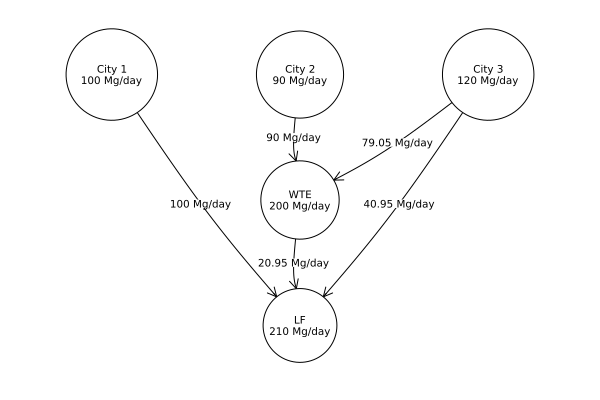

In [53]:
# Define sets as named above
I = [1, 2, 3]
J = [1, 2, 3]

# Define given parameters as named above
P = [100, 90, 120]
C = [200, 350, 210]
fixCost = [2000, 1500, 2500]
tipCost = [50, 7, 60]
recCost = 40
tranCost = 1.5
recRate = 0.4
ashRateN = 0.16
ashRateR = 0.14
distW = [[5, 15, 13];; [30, 25, 45];; [15, 10, 20]]
distR = [[0, 32, 18];; [32, 0, 15];; [18, 15, 0]]
M = sum(P)

# Define variables, objective, and constraints as defined above
waste_model = Model(HiGHS.Optimizer)
@variable(waste_model, W[i in I, j in J] >= 0)
@variable(waste_model, R[k in J, j in J] >= 0)
@variable(waste_model, Y[j in J], Bin)
@objective(waste_model, Min, sum(Y[j]*fixCost[j] + sum(W[i,j] * (tipCost[j] + tranCost*distW[i,j]) for i in I) + sum(R[k,j] * (tipCost[j] + tranCost*distR[k,j]) for k in J) for j in J) + sum(recRate*recCost*W[i,2] for i in I))

sourceProduction = @constraint(waste_model, [i = I], sum(W[i,j] for j in J) == P[i], base_name = "sourceProduction")
wasteCapacity = @constraint(waste_model, [j = J], sum(W[i,j] for i in I) + sum(R[k, j] for k in J) <= C[j], base_name = "wasteCapacity")
wasteOperation = @constraint(waste_model, [j = J], M*Y[j] >= (sum(W[i,j] for i in I) + sum(R[k,j] for k in J)), base_name = "wasteOperation")
@constraint(waste_model, MRFWaste, (1-recRate)*sum(W[i,2] for i in I) == R[2,1] + R[2,3])
@constraint(waste_model, WTEAshe, ashRateN*sum(W[i,3] for i in I) + ashRateR*R[2,3] == R[3,1])
@constraint(waste_model, R[1,1] == 0)
@constraint(waste_model, R[1,2] == 0)
@constraint(waste_model, R[1,3] == 0)
@constraint(waste_model, R[2,2] == 0)
@constraint(waste_model, R[3,2] == 0)
@constraint(waste_model, R[3,3] == 0)

print(waste_model)

# Solve the defined model, optimizing for maximum profit
optimize!(waste_model)

for i in I
    for j in J
        print("W[" * string(i) * ", " * string(j) * "] = " * string(value.(W)[i,j]) * "\n")
    end
end

for k in J
    for j in J
        print("R[" * string(k) * ", " * string(j) * "] = " * string(value.(R)[k,j]) * "\n")
    end
end

# 1,2,3,4,5 = City1, City2, City3, WTE, LF
g = [0 0 0 0 1;
    0 0 0 1 0;
    0 0 0 1 1;
    0 0 0 0 1;
    0 0 0 0 0]
n = ["City 1\n100 Mg/day", "City 2\n90 Mg/day", "City 3\n120 Mg/day", "WTE\n200 Mg/day", "LF\n210 Mg/day"]

graphplot(g,
    x = [-1.5, 0, 1.5, 0, 0],
    y = [0.5, 0.5, 0.5, -0.5, -1.5],
    names = n,
    markercolor = colorant"white",
    nodeshape = :circle,
    nodesize = 0.15,
    axis_buffer = 0.25,
    edgelabel = Dict((1, 5) => "100 Mg/day", (2, 4) => "90 Mg/day", (3, 4) => "79.05 Mg/day", (3, 5) => "40.95 Mg/day", (4, 5) => "20.95 Mg/day"))
    

As can be seen in the above graph, the MRF is not utilized for waste disposal. This makes sense for a few different reasons. First of all, 60% of all waste input into the MRF must eventually be wasted at another facility, and the 40% that is recycled is done so at a barely cheaper price than landfill (\\$40/Mg vs \\$50/Mg). This means that the reamining 60% of all waste input into the MRF incurrs costs for travel to the MRF, tipping cost at the MRF, and cost of travel to the WTE or LF afterwards. And, any benefit this may result in must also offset the fixed cost of building the MRF. Paired with the realtively far distances between the MRF and all cities and other facilities, the model determines that the MRF is not worth the fixed cost to build, and all waste can be handled by the capacity of the WTE and LF.

### References

List any external references consulted, including classmates.